# 24. Indian Ocean carbonate preservation and green band abundances at Site U1474
Here i compare an index for bottom water corrosiveness based on foraminifera shell fragmentation from a composite of Central Indian Ocean core sites from [Bassinot et al 1995 "Coarse fraction fluctuations in pelagic carbonate sediments from the tropical Indian Ocean: A 1500-kyr record of carbonate dissolution"](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/94PA00860?casa_token=IVaAndrFVagAAAAA:eLhIcZtbbIAdMKTINjWpvUD9QDBv64xIflz-7kAPwthmlQdO2XxsyfrMs6aKf9MLeXhtHwMUhoiZQLUH) to green band abundance to connect potential sources of bottom water to mechanisms that can drive the formation of green bands.

This notebook produces supplementary figure 11.

## Setup
### Import modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy import signal,interpolate,stats,linalg
from IPython.display import clear_output
import time
import numpy as np
import seaborn as sns
%matplotlib inline

### Set paths

In [2]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
core_photos='/Users/danielbabin/GitHub/Green_Bands/CorePhotos/LowRes/'
figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Main/'
sup_figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Supplementary/'
misc_path='/Users/danielbabin/GitHub/Green_Bands/Data/Misc/'

### Import data
#### U1474

In [3]:
green_layers=pd.read_csv(table_path+'Supplementary Table 6A - U1474 green bands.csv')
green_true=green_layers.copy()

In [4]:
am=pd.read_csv(table_path+'Supplementary Table 2 - Age-depth model.csv')
am['Top Interval Depth CCSF (m)']=am['Depth CCSF (m)'].shift(1)
am['Top Interval Age (kyr)']=am['Age (kyr)'].shift(1)
fam=interpolate.interp1d(am['Depth CCSF (m)'],am['Age (kyr)'],bounds_error=False)

In [5]:
green_true['Top Age (kyr)']=fam(green_true['Top Depth CCSF (m)'])
green_true['Bottom Age (kyr)']=fam(green_true['Bottom Depth CCSF (m)'])
agtU1474=green_true[~green_true['Bottom Age (kyr)'].isnull()].set_index('Bottom Age (kyr)',drop=False).sort_index()

### Coarse fraction weight

In [32]:
cf=pd.read_csv('/Users/danielbabin/GitHub/Natal_Valley_Green_Layers/Data/U1474Samples&CFWeight.csv',index_col='Top Depth (m CCSF)')
cf['Depositional Age (ka)']=fam(cf.index)
acf=cf[cf['Depositional Age (ka)'].isnull()==False].copy().set_index('Depositional Age (ka)')
acf=acf[acf['Coarse Fraction wt%']<40].copy()

In [36]:
#remove sand layers

<Axes: xlabel='Depositional Age (ka)'>

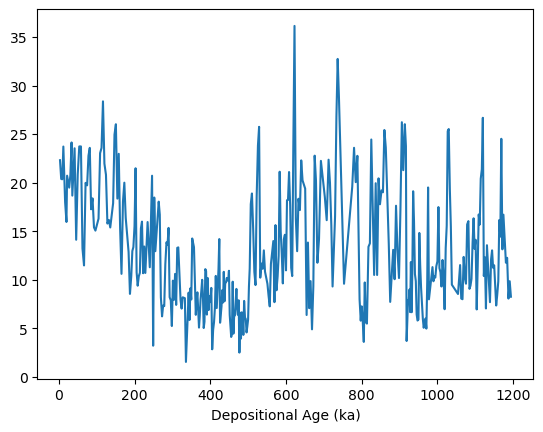

In [34]:
acf['Coarse Fraction wt%'].loc[0:1200].plot()

#### Glacials

In [37]:
glacials=[[14, 29],[57, 71],[130, 191],[243, 300],[337, 374],[424, 478],[524, 563],[621, 676],
          [712, 761],[790, 814],[866, 900],[917, 936],[959, 970],[982, 1014],[1031, 1062],[1081,1104],
          [1114, 1141],[1190,1215],[1240,1265],[1285,1300],[1320,1344],[1365,1382],[1407,1424],
          [1453,1468],[1494,1510],[1531,1546],[1571,1583],[1642,1669],[1699,1712],[1744,1754],
          [1785,1802],[1860,1871],[1899,1914],[1941,1965],[1996,2016]]

#### Carbonate Chemistry

In [38]:
bassenot=pd.read_csv(misc_path+'bassenot-1995-ccfi.csv',index_col='Age (ka)')

### Create green band abundance record

In [39]:
bintest={}

In [71]:
step=1
bin_edges=np.arange(0,5235+step,step,dtype=int)

In [72]:
col_list=['U1474','U1474_C2+', 'U1474_C3', 
          '1313', '1313_C2+', '1313_C3']

In [73]:
thickness_records=pd.DataFrame(0,index=bin_edges,columns=col_list)
number_records=pd.DataFrame(0,index=bin_edges,columns=col_list)
for i,site in enumerate([agtU1474]):
# for i,site in enumerate([agtU1474,agt1313,agt659,agt1143,agt758,agtU1489]):
    sitename=site['Site'].iloc[0]
    nearest=np.round(site.index/step)*step
    site['Nearest']=nearest
    
    thicknesses_total=site.groupby('Nearest').sum(numeric_only=True)['Thickness (cm)']
    thicknesses_c2_plus=site[site['Class']>1].groupby('Nearest').sum(numeric_only=True)['Thickness (cm)']
    thicknesses_c3=site[site['Class']==3].groupby('Nearest').sum(numeric_only=True)['Thickness (cm)']
    thickness_records.loc[thicknesses_total.index,str(sitename)]=thicknesses_total.values
    thickness_records.loc[thicknesses_c2_plus.index,str(sitename)+'_C2+']=thicknesses_c2_plus.values
    thickness_records.loc[thicknesses_c3.index,str(sitename)+'_C3']=thicknesses_c3.values

    number_total=site.groupby('Nearest').count().iloc[:,0]
    number_c2_plus=site[site['Class']>1].groupby('Nearest').count().iloc[:,0]
    number_c3=site[site['Class']==3].groupby('Nearest').count().iloc[:,0]
    number_records.loc[number_total.index,str(sitename)]=number_total.values
    number_records.loc[number_c2_plus.index,str(sitename)+'_C2+']=number_c2_plus.values
    number_records.loc[number_c3.index,str(sitename)+'_C3']=number_c3.values

## Make figure

In [74]:
colors=sns.color_palette('colorblind')

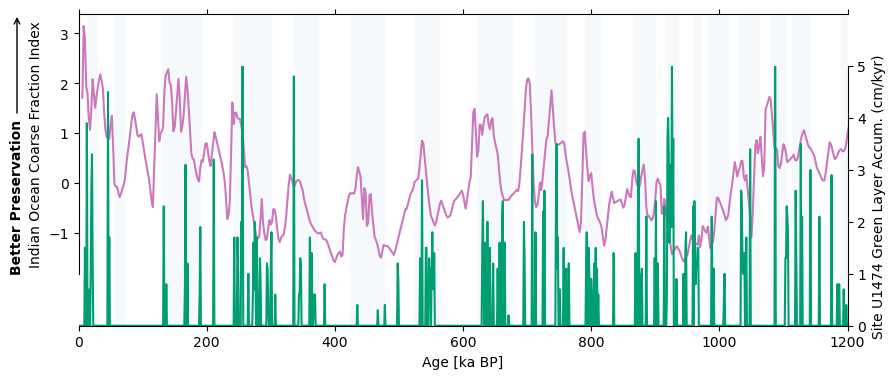

In [75]:
fig,axes=plt.subplots(nrows=2,sharex=True,figsize=(9,4))
sns.despine(ax=axes[0],top=False,bottom=True)
sns.despine(ax=axes[1],top=True,bottom=False,left=True,right=False)


for ax in axes:
    ax.patch.set_visible(False)
axes[1].yaxis.set_label_position('right')

ax=axes[0]
bassenot['CCFI'].plot(ax=ax,color=colors[4])
ax.set_ylabel('Indian Ocean Coarse Fraction Index')
ax.annotate('Better Preservation',xy=(-.08,1),xytext=(-.08,0),ha='center',va='bottom',xycoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),rotation=90,fontweight='bold')

ax=axes[1]
thickness_records['U1474'].loc[0:1500].plot(ax=ax,color=colors[2])
ax.set_ylim(0,5)
ax.set_xlabel('Age [ka BP]')
ax.set_ylabel('Site U1474 Green Layer Accum. (cm/kyr)')

ax=axes[0]
for g in glacials:
    start=g[0]
    end=g[1]
    ax.axvspan(xmin=start,xmax=end,zorder=-10,color='#f5f9fb')
ax=axes[1]
for g in glacials:
    start=g[0]
    end=g[1]
    ax.axvspan(xmin=start,xmax=end,ymax=.2,zorder=-10,color='#f5f9fb')
ax.set_xlim(0,1200)

plt.tight_layout()
plt.subplots_adjust(hspace=-.8)
figname='Extended Data Figure 11 - Indian Ocean carbonate preservation and green band abundances at Site U1474.png'
fig.savefig(sup_figure_path+figname,dpi=300)

(0.0, 1200.0)

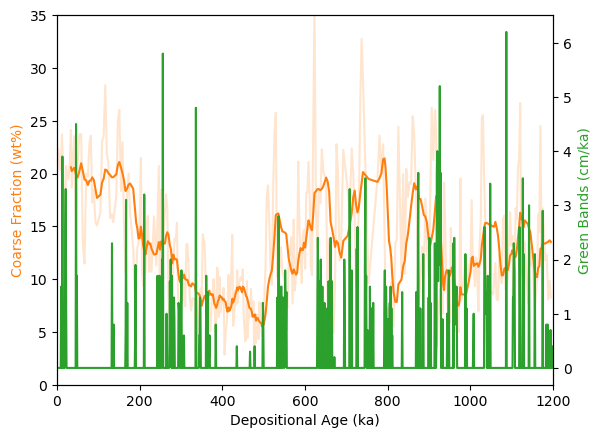

In [76]:
ax=acf.loc[0:1200,'Coarse Fraction wt%'].dropna().plot(alpha=.2,color='tab:orange')
acf.loc[0:1200,'Coarse Fraction wt%'].dropna().rolling(10).mean().plot(ax=ax,color='tab:orange')
ax.set_ylim(0,35)
sec=thickness_records['U1474'].loc[0:1500].plot(secondary_y=True,color='tab:green')
ax.set_ylabel('Coarse Fraction (wt%)',color='tab:orange')
sec.set_ylabel('Green Bands (cm/ka)',color='tab:green')
ax.set_xlim(0,1200)

(0.0, 1200.0)

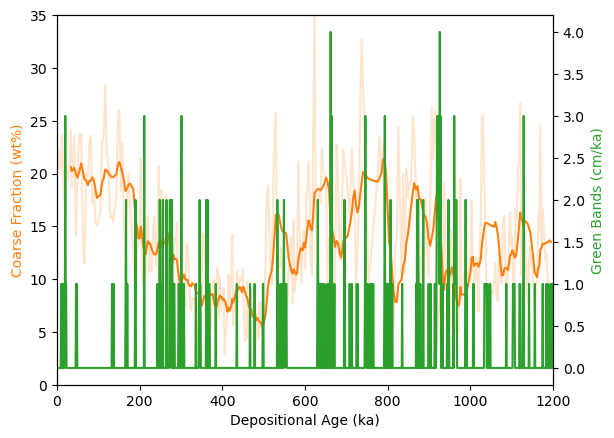

In [77]:
ax=acf.loc[0:1200,'Coarse Fraction wt%'].dropna().plot(alpha=.2,color='tab:orange')
acf.loc[0:1200,'Coarse Fraction wt%'].dropna().rolling(10).mean().plot(ax=ax,color='tab:orange')
ax.set_ylim(0,35)
sec=number_records['U1474'].loc[0:1500].plot(secondary_y=True,color='tab:green')
ax.set_ylabel('Coarse Fraction (wt%)',color='tab:orange')
sec.set_ylabel('Green Bands (cm/ka)',color='tab:green')
ax.set_xlim(0,1200)